In [34]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from runner import test_run

Load csv data for DC current calibration sweeps. In each test, one of our hall sensors (measuring current to top or bottom ESC) was supplied with a fixed current from a switching DC power supply in current control mode. Ground truth currents were supplied in 0.25 A increments from 0 to 2.5A.

In [35]:
in_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/bottom_motor_power_supply_sweep.csv"
out_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/bottom_motor_ps_sweep1_formatted.csv"


with open(in_fnam, newline='') as in_file:
    with open(out_fnam, 'w', newline='') as out_file:
        writer = csv.writer(out_file)
        for row in csv.reader(in_file):
            if row:
                writer.writerow(row)

In [36]:
in_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/top_motor_power_supply_sweep.csv"
out_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/top_motor_ps_sweep1_formatted.csv"

with open(in_fnam, newline='') as in_file:
    with open(out_fnam, 'w', newline='') as out_file:
        writer = csv.writer(out_file)
        for row in csv.reader(in_file):
            if row:
                writer.writerow(row)

In [37]:
bot_motor_data = test_run("../test_data/thrust_jig_calibration_data/hall_sensor/bottom_motor_ps_sweep1_formatted.csv")
top_motor_data = test_run("../test_data/thrust_jig_calibration_data/hall_sensor/top_motor_ps_sweep1_formatted.csv")

Loading saved data
Loading saved data


Since the DC power supply output was controlled by hand, we need to manually select the time windows for each current input :(

In [38]:
bot_hall_current = bot_motor_data["bottom_current_A"].iloc[:-30000]
bot_time_ms = bot_motor_data.index[:-30000]

bottom_throttle_ranges = [[2000, 7000],[17000, 22000],[30000, 40000],[48000, 53000],[62000, 67000], [74000, 79000], 
                          [87000, 97000], [105000, 110000], [120000, 125000], [135000, 140000], [145000, 150000]]

In [39]:
top_hall_current = top_motor_data["top_current_A"].iloc[:-10000]
top_time_ms = top_motor_data.index[:-10000]
top_throttle_ranges = [[5000, 16000], [21000, 32000], [40000, 47000], [55000, 65000], [75000, 81000], [88000, 94000],
                       [100000, 110000], [120000, 126000], [134000, 142000], [152000, 160000], [167000, 185000]]

Take the mean and standard deviation of each constant current sampling period

In [40]:
bot_current_mean = [np.mean(bot_hall_current.iloc[np.argmin(np.abs(bot_time_ms-bottom_throttle_ranges[i][0])):np.argmin(np.abs(bot_time_ms-bottom_throttle_ranges[i][1]))]) for i in range(len(bottom_throttle_ranges))]
top_current_mean = [np.mean(top_hall_current.iloc[np.argmin(np.abs(top_time_ms-top_throttle_ranges[i][0])):np.argmin(np.abs(top_time_ms-top_throttle_ranges[i][1]))]) for i in range(len(top_throttle_ranges))]

bot_current_err = [np.std(bot_hall_current.iloc[np.argmin(np.abs(bot_time_ms-bottom_throttle_ranges[i][0])):np.argmin(np.abs(bot_time_ms-bottom_throttle_ranges[i][1]))]) for i in range(len(bottom_throttle_ranges))]
top_current_err = [np.std(top_hall_current.iloc[np.argmin(np.abs(top_time_ms-top_throttle_ranges[i][0])):np.argmin(np.abs(top_time_ms-top_throttle_ranges[i][1]))]) for i in range(len(top_throttle_ranges))]

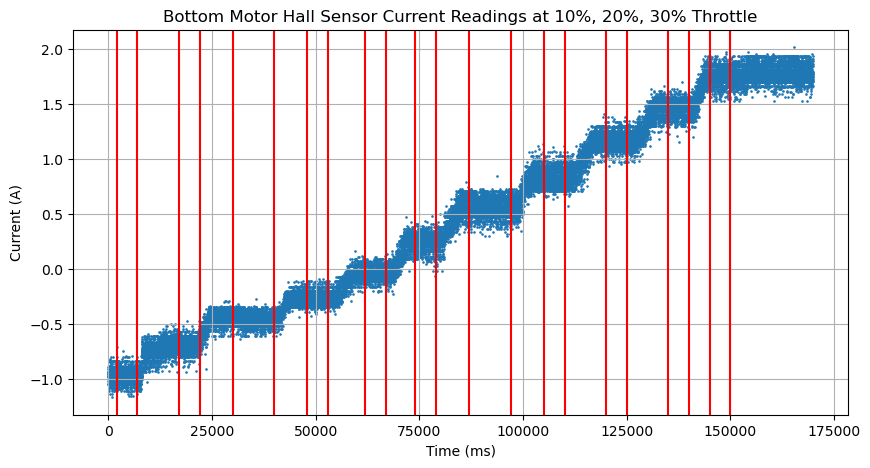

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(bot_time_ms, bot_hall_current, s=0.8)
for i in range(len(bottom_throttle_ranges)):
    plt.axvline(bottom_throttle_ranges[i][0], color='r')
    plt.axvline(bottom_throttle_ranges[i][1], color='r')
plt.xlabel("Time (ms)")
plt.ylabel("Current (A)")
plt.title("Bottom Motor Hall Sensor Current Readings at 10%, 20%, 30% Throttle")
plt.grid()
plt.show()

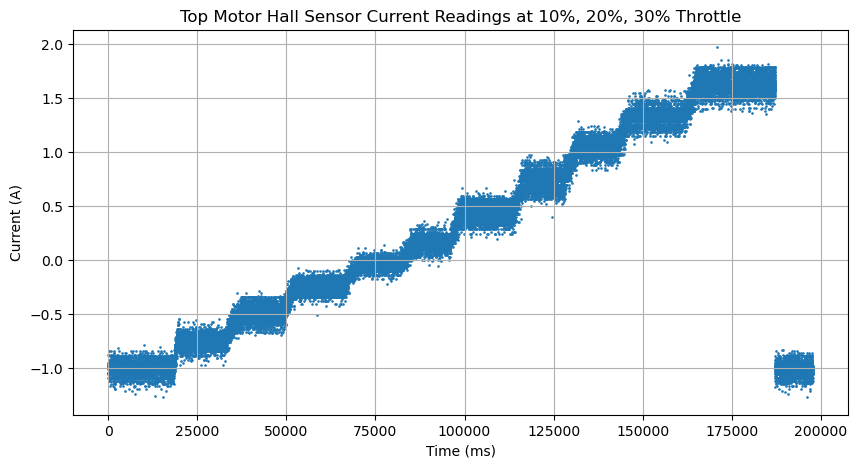

In [42]:
plt.figure(figsize=(10,5))
plt.scatter(top_time_ms, top_hall_current, s=0.8)

# for i in range(len(top_throttle_ranges)):
#     plt.axvline(top_throttle_ranges[i][0], color='r')
#     plt.axvline(top_throttle_ranges[i][1], color='r')

plt.xlabel("Time (ms)")
plt.ylabel("Current (A)")
plt.title("Top Motor Hall Sensor Current Readings at 10%, 20%, 30% Throttle")
plt.grid()
plt.show()

In [43]:
source_current_A = np.arange(0, 2.51, 0.25)
source_current_A

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ])

Plot ground truth current as a function of measured current

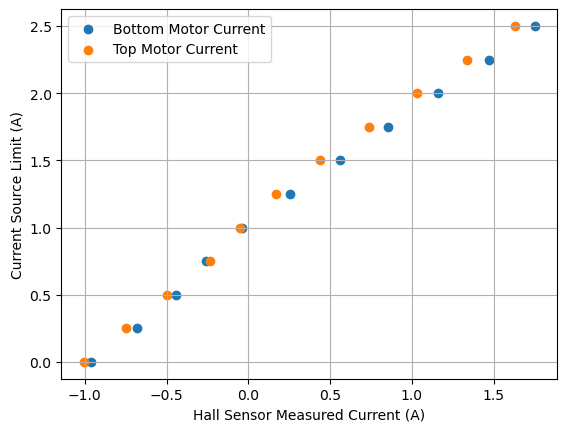

In [44]:
plt.figure()
plt.scatter(bot_current_mean, source_current_A, label="Bottom Motor Current")
plt.scatter(top_current_mean, source_current_A, label="Top Motor Current")
plt.xlabel("Hall Sensor Measured Current (A)")
plt.ylabel("Current Source Limit (A)")
plt.legend()
plt.grid()
plt.show()

Develop a function which linearly approximates the relationship between ground truth and test jig measured current:

$$I_{real} = A I_{meas} + B$$

In [45]:
def calibrated_current(measured_current, gain, offset):
    return gain * measured_current + offset

In [46]:
from scipy.optimize import curve_fit

### Measurement Uncertainty
The ACS712 data sheet specifies a total output error of +/- 1.5% for a 30 A measurement range. This corresponds to a $\sigma = 0.015 \times 30 = 0.45 A$

In [51]:
bot_popt,bot_pcov = curve_fit(calibrated_current, bot_current_mean, source_current_A, sigma=bot_current_err, absolute_sigma=True)
top_popt,top_pcov = curve_fit(calibrated_current, top_current_mean, source_current_A, sigma=top_current_err, absolute_sigma=True)
current = np.linspace(-1, 2, 2)

bot_perr = np.sqrt(np.diag(bot_pcov))
top_perr = np.sqrt(np.diag(top_pcov))
total_perr = [np.sqrt(np.mean([bot_perr[0]**2, top_perr[0]**2])), bot_perr[1] + top_perr[1]]
print(total_perr)

[0.02294010910125233, 0.03734182990750414]


The combined uncertainty for a current measurement which sums top motor and bottom motor hall sensor readings is a linear function of the measured current $I_{tot}$

$$\sigma_{tot} = 0.02294 \cdot I_{tot} + 0.03734\; A$$

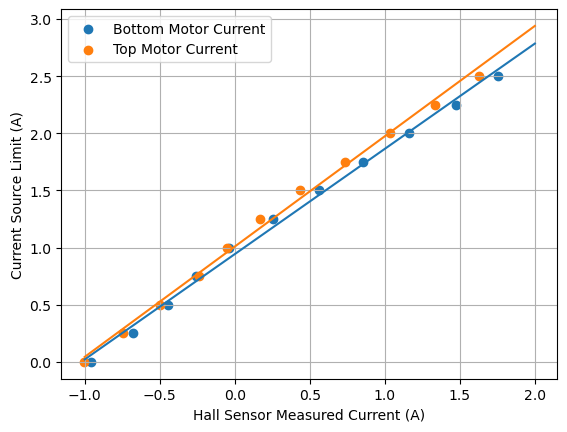

In [49]:
plt.figure()
plt.scatter(bot_current_mean, source_current_A, label="Bottom Motor Current")
plt.scatter(top_current_mean, source_current_A, label="Top Motor Current")
plt.plot(current, calibrated_current(current, bot_popt[0], bot_popt[1]))
plt.plot(current, calibrated_current(current, top_popt[0], top_popt[1]))

plt.xlabel("Hall Sensor Measured Current (A)")
plt.ylabel("Current Source Limit (A)")
plt.legend()
plt.grid()
plt.show()

In [50]:
print("Top Motor Calibration: " + str(top_popt[0]) + " I + " + str(top_popt[1]))
print("Bottom Motor Calibration: " + str(bot_popt[0]) + " I + " + str(bot_popt[1]))

Top Motor Calibration: 0.9652433922548949 I + 1.0091614446200308
Bottom Motor Calibration: 0.9210661934305282 I + 0.943072677155169


Using a linear least squares curve fit, we can relate test jig outputs to ground truth inputs

In [17]:
in_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/bottom_motor_power_supply_sweep_2.csv"
out_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/bottom_motor_ps_sweep2_formatted.csv"

with open(in_fnam, newline='') as in_file:
    with open(out_fnam, 'w', newline='') as out_file:
        writer = csv.writer(out_file)
        for row in csv.reader(in_file):
            if row:
                writer.writerow(row)

In [18]:
in_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/top_motor_power_supply_sweep_2.csv"
out_fnam = "../test_data/thrust_jig_calibration_data/hall_sensor/top_motor_ps_sweep2_formatted.csv"

with open(in_fnam, newline='') as in_file:
    with open(out_fnam, 'w', newline='') as out_file:
        writer = csv.writer(out_file)
        for row in csv.reader(in_file):
            if row:
                writer.writerow(row)

In [19]:
bot_motor_validation_data = test_run("../test_data/thrust_jig_calibration_data/hall_sensor/bottom_motor_ps_sweep2_formatted.csv")
top_motor_validation_data = test_run("../test_data/thrust_jig_calibration_data/hall_sensor/top_motor_ps_sweep2_formatted.csv")

Loading saved data
Loading saved data


In [20]:
bot_current_calibrated = bot_popt[0] * bot_motor_validation_data["bottom_current_A"] + bot_popt[1]
top_current_calibrated = top_popt[0] * top_motor_validation_data["top_current_A"] + top_popt[1]

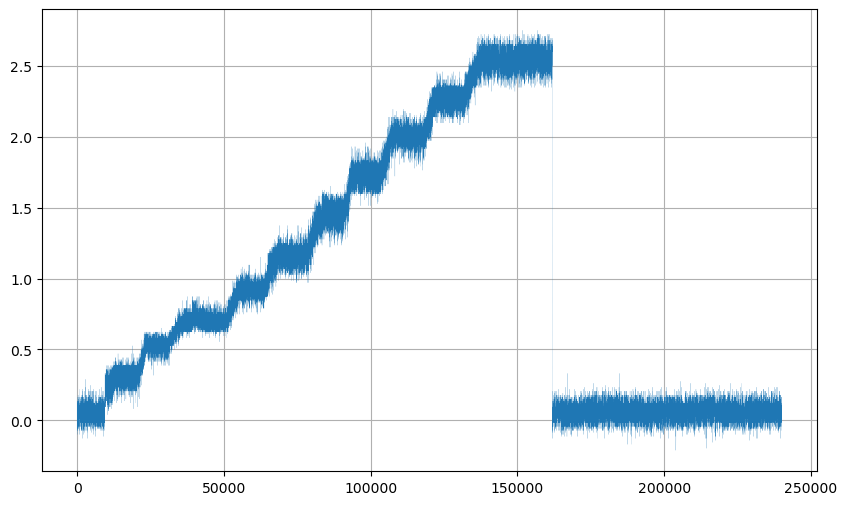

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(bot_current_calibrated, linewidth=0.1)
#plt.plot(top_current_calibrated)
plt.grid()
plt.show()